This notebook walks you through some of SpECTRE's functionality.

# Using the SpECTRE Python bindings

We will use the TOV solution implemented in SpECTRE to compute the mass profile of a star.

1. Load the Python modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import spectre.PointwiseFunctions.AnalyticSolutions.GeneralRelativity as spectre_gr
import spectre.PointwiseFunctions.Hydro.EquationsOfState as spectre_eos

2. Construct an equation of state:

In [3]:
eos = spectre_eos.RelativisticPolytropicFluid(polytropic_constant=8, polytropic_exponent=2)

3. Construct a TOV star with central mass-density $\rho_\mathrm{c}=10^{-3}$ and the equation of state:

In [4]:
tov = spectre_gr.Tov(equation_of_state=eos, central_mass_density=1e-3)

4. Output the star's radius and total mass:

In [5]:
R = tov.outer_radius()
M = tov.mass(R)
R, M

(3.4685521334560225, 0.05310369405512771)

5. Plot the star's mass profile:

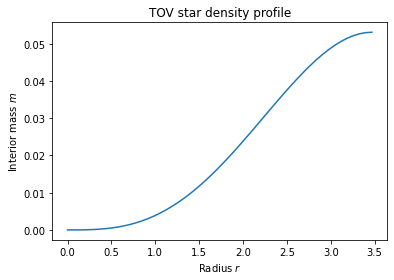

In [6]:
r = np.linspace(0, R)
m = tov.mass(r)

plt.title("TOV star density profile")
plt.plot(r, m)
plt.xlabel(r"Radius $r$")
plt.ylabel(r"Interior mass $m$");

# Running an executable

1. Build the executable:

In [7]:
!cd $SPECTRE_HOME/build && make -j2 SolvePoissonProductOfSinusoids1D

[  0%] Built target module_Main
[  0%] Built target SpectrePchLib
[  0%] Built target module_GlobalCache
[  0%] Built target SpectrePch
[  6%] Built target ErrorHandling
[ 12%] Built target Utilities
[ 12%] Built target Informer
[ 18%] Built target DataStructures
[ 18%] Built target Parallel
[ 18%] Built target Convergence
[ 25%] Built target Time
[ 31%] Built target PoissonSolutions
[ 31%] Built target MathFunctions
[ 31%] Built target FunctionsOfTime
[ 37%] Built target Spectral
[ 37%] Built target LinearSolver
[ 43%] Built target DomainStructure
[ 62%] Built target GeneralRelativity
[ 68%] Built target LinearOperators
[ 68%] Built target DiscontinuousGalerkin
[ 75%] Built target IO
[ 81%] Built target Domain
[ 87%] Built target CoordinateMaps
[ 93%] Built target DomainTimeDependence
[100%] Built target DomainCreators
[100%] Built target Poisson
[100%] Built target SolvePoissonProductOfSinusoids1D


2. Configure the input file:

In [8]:
!cp $SPECTRE_HOME/tests/InputFiles/Poisson/ProductOfSinusoids1D.yaml ./
!sed -i 's/InitialGridPoints: \[3\]$/InitialGridPoints: \[5\]/g' ProductOfSinusoids1D.yaml
!sed -i 's/MaxIterations: 1$/MaxIterations: 100/g' ProductOfSinusoids1D.yaml
!sed -i 's/RelativeResidual: 0$/RelativeResidual: 1e-10/g' ProductOfSinusoids1D.yaml

3. Run the executable:

In [9]:
!rm PoissonProductOfSinusoids1D*.h5
!$SPECTRE_HOME/build/bin/SolvePoissonProductOfSinusoids1D --input-file ProductOfSinusoids1D.yaml

Charm++> No provisioning arguments specified. Running with a single PE.
         Use +auto-provision to fully subscribe resources or +p1 to silence this message.
Charm++: standalone mode (not using charmrun)
Charm++> Running in Multicore mode: 1 threads (PEs)
Converse/Charm++ Commit ID: v6.10.2-0-g7bf00fad3
Warning> Randomization of virtual memory (ASLR) is turned on in the kernel, thread migration may not work! Run 'echo 0 > /proc/sys/kernel/randomize_va_space' as root to disable it, or try running with '+isomalloc_sync'.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 1 cores x 2 PUs = 2-way SMP)
Charm++> cpu topology info is gathered in 0.000 seconds.

Executing '/work/spectre/build/bin/SolvePoissonProductOfSinusoids1D' using 1 processors.
Date and time at startup: Sat Sep 12 12:39:14 2020

SpECTRE Build Information:
Version:                      0.0.0
Compiled on host:             e3d14318ae5d
Compiled in directory:        /work/spectre/bu

4. Plot reductions data:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import spectre.IO.H5 as spectre_h5
import spectre.DataStructures

In [11]:
reductions_file = spectre_h5.H5File('PoissonProductOfSinusoids1DReductions.h5', True)

In [12]:
iterations, residuals = np.asarray(reductions_file.get_dat('/LinearSolverResiduals').get_data()).T

Text(0, 0.5, 'Residual')

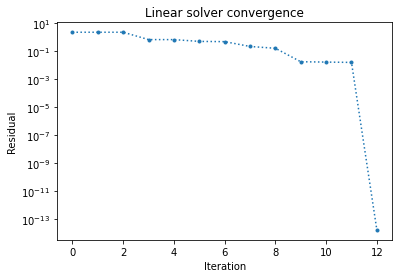

In [13]:
plt.title('Linear solver convergence')
plt.semilogy(iterations, residuals, marker='.', ls='dotted')
plt.xlabel('Iteration')
plt.ylabel('Residual')

In [14]:
reductions_file.close()

5. Plot volume data:

In [15]:
volume_file = spectre_h5.H5File('PoissonProductOfSinusoids1DVolume0.h5', True)

In [16]:
volume_data = volume_file.get_vol('/VolumeData')

In [17]:
obs_id = sorted(volume_data.list_observation_ids(), key=volume_data.get_observation_value)[-1]

In [18]:
x = np.asarray(volume_data.get_tensor_component(obs_id, 'InertialCoordinates_x'))
u = np.asarray(volume_data.get_tensor_component(obs_id, 'Field'))

In [19]:
grids = volume_data.get_grid_names(obs_id)
extents = volume_data.get_extents(obs_id)

In [20]:
from scipy.interpolate import lagrange

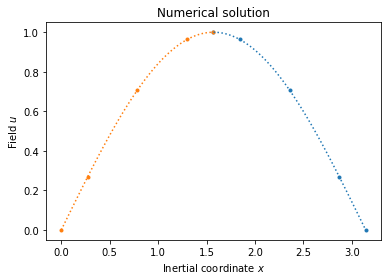

In [21]:
plt.title('Numerical solution')
for grid in grids:
    offset, length = spectre_h5.offset_and_length_for_grid(grid, grids, extents)
    x_grid = x[offset:offset + length]
    u_grid = u[offset:offset + length]
    plt.scatter(x_grid, u_grid, marker='.')
    x_space = np.linspace(x_grid[0], x_grid[-1], 100)
    plt.plot(x_space, lagrange(x_grid, u_grid)(x_space),
        ls='dotted')
plt.xlabel('Inertial coordinate $x$')
plt.ylabel('Field $u$');